In [4]:
%pip install scikit-learn
%pip install torch
%pip install matplotlib
%pip install pandas
%pip install chess

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl.metadata (22 kB)
Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import chess
import chess.pgn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import chess.polyglot

In [7]:
csvs = []
for csv in os.listdir("./lichess/data_1/"):
    csvs.append(csv)
len(csvs)

54

In [8]:
def prepare_data(df, batch_size):
    targets_numpy = df.result.values
    features_numpy = df.loc[:,df.columns != "result"].values

    features_train, features_test, targets_train, targets_test = train_test_split(
        features_numpy,
        targets_numpy,
        test_size = 0.2,
        random_state = random.randint(0,1000)
    )

    featuresTrain = torch.from_numpy(features_train).type(torch.float32)
    targetsTrain = torch.from_numpy(targets_train).type(torch.float32)

    featuresTest = torch.from_numpy(features_test).type(torch.float32)
    targetsTest = torch.from_numpy(targets_test).type(torch.float32)

    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
    test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

    # data loader
    train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test, batch_size = batch_size, shuffle = True)

    return train_loader, test_loader

In [9]:
def threshold_tensor(x, threshold=0.5):
    thresholded_x = (x >= threshold).float()
    return thresholded_x

In [10]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_0, hidden_dim_1, hidden_dim_2, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_0)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim_0, hidden_dim_1)
        self.tanh2 = nn.Tanh()

        self.fc3 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.elu3 = nn.ELU()

        self.fc4 = nn.Linear(hidden_dim_2, output_dim)

        self.sig4 = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)

        out = self.fc2(out)
        out = self.relu1(out)

        out = self.fc3(out)
        out = self.relu1(out)

        out = self.fc4(out)

        out = self.sig4(out)

        return out

In [46]:
# Code for testing the best algorithm for training
# Formatted by ChatGPT
error = nn.BCELoss()
val_error = nn.BCELoss()
learning_rate = 0.01
input_dim = 1088
hidden_dim_0 = 1024
hidden_dim_1 = 512
hidden_dim_2 = 256
output_dim = 1
batch_size = 128

optimizer_dict = {
    "Adadelta": torch.optim.Adadelta,
    "Adagrad": torch.optim.Adagrad,
    "Adam": torch.optim.Adam,
    "Adamax": torch.optim.Adamax,
    "ASGD": torch.optim.ASGD,
    "NAdam": torch.optim.NAdam,
    "RAdam": torch.optim.RAdam,
    "RMSprop": torch.optim.RMSprop,
    "Rprop": torch.optim.Rprop,
    "SGD": torch.optim.SGD,
    "SGD-Momentum": torch.optim.SGD,
}

accuracy_results = {}
loss_results = {}
train_index = random.randint(0,len(csvs) - 1)
while True:
    test_index = random.randint(0, len(csvs) - 1)
    if train_index != test_index:
        break
        
print(f"TRAIN_INDEX: {train_index}")
print(f"TEST_INDEX: {test_index}")

for algo_name, optimizer_class in optimizer_dict.items():
    model = ANNModel(input_dim, hidden_dim_0, hidden_dim_1, hidden_dim_2, output_dim)
    
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    
    print(algo_name)
    
    accuracy_list = []
    loss_list = []
    train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
    test_df = pd.read_csv("./lichess/data_1/" + csvs[test_index])
    train_loader, test_loader = prepare_data(train_df, batch_size)
#     _, test_loader = prepare_data(test_df, batch_size)
    max_accuracy = 0
    min_loss = float('inf')
    epoch_count = 0

    while True:
        for _, (boards, labels) in enumerate(train_loader):
            train = Variable(boards.view(-1, input_dim))
            labels = Variable(labels.view(-1, 1))
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            loss.backward()
            optimizer.step()

        correct = 0
        total = 0

        for boards, labels in test_loader:
            test = Variable(boards.view(-1, input_dim))
            outputs = model(test)
            val_loss = val_error(outputs, labels.view(-1, 1)).detach().item()
            predicted = threshold_tensor(outputs)
            total += len(labels)
            correct += (predicted.flatten() == labels).sum()

        accuracy = 100 * correct / float(total)
        print(f"ACCURACY: {round(float(accuracy), 2)}%, LOSS: {round(float(val_loss), 4)}")
        
        if accuracy > max_accuracy:
            max_accuracy = accuracy

        if val_loss < min_loss:
            min_loss = val_loss
            epoch_count = 0
        else:
            epoch_count += 1

        accuracy_list.append(accuracy)
        loss_list.append(val_loss)

        if epoch_count >= 10:
            print(f"MAX_ACCURACY: {max_accuracy}")
            print(f"MIN_LOSS: {min_loss}")
            break
                
    accuracy_list_float = [float(tensor) for tensor in accuracy_list]
    loss_list_float = [float(tensor) for tensor in loss_list]
    accuracy_results[algo_name] = accuracy_list_float
    loss_results[algo_name] = loss_list_float

TRAIN_INDEX: 42
TEST_INDEX: 35
Adadelta
ACCURACY: 50.43%, LOSS: 0.6926
ACCURACY: 51.34%, LOSS: 0.6922
ACCURACY: 54.28%, LOSS: 0.691
ACCURACY: 55.98%, LOSS: 0.691
ACCURACY: 55.41%, LOSS: 0.6925
ACCURACY: 55.78%, LOSS: 0.6931
ACCURACY: 55.64%, LOSS: 0.6905
ACCURACY: 56.48%, LOSS: 0.6891
ACCURACY: 57.15%, LOSS: 0.6852
ACCURACY: 58.1%, LOSS: 0.6773
ACCURACY: 59.2%, LOSS: 0.6844
ACCURACY: 59.82%, LOSS: 0.6747
ACCURACY: 60.62%, LOSS: 0.6685
ACCURACY: 60.74%, LOSS: 0.6338
ACCURACY: 61.94%, LOSS: 0.6724
ACCURACY: 62.93%, LOSS: 0.6152
ACCURACY: 63.3%, LOSS: 0.6746
ACCURACY: 64.1%, LOSS: 0.6243
ACCURACY: 64.39%, LOSS: 0.6629
ACCURACY: 65.98%, LOSS: 0.6429
ACCURACY: 66.33%, LOSS: 0.5987
ACCURACY: 67.43%, LOSS: 0.5577
ACCURACY: 68.1%, LOSS: 0.5665
ACCURACY: 69.32%, LOSS: 0.5757
ACCURACY: 69.5%, LOSS: 0.6132
ACCURACY: 71.67%, LOSS: 0.6127
ACCURACY: 72.63%, LOSS: 0.5281
ACCURACY: 74.15%, LOSS: 0.5467
ACCURACY: 76.18%, LOSS: 0.4925
ACCURACY: 74.47%, LOSS: 0.4771
ACCURACY: 78.3%, LOSS: 0.4434
ACCURACY

ACCURACY: 82.0%, LOSS: 0.3198
ACCURACY: 81.59%, LOSS: 0.2618
ACCURACY: 81.83%, LOSS: 0.337
ACCURACY: 82.15%, LOSS: 0.3004
ACCURACY: 81.85%, LOSS: 0.2637
ACCURACY: 82.04%, LOSS: 0.2495
ACCURACY: 82.68%, LOSS: 0.272
ACCURACY: 82.68%, LOSS: 0.2927
ACCURACY: 82.57%, LOSS: 0.3211
MAX_ACCURACY: 82.6796875
MIN_LOSS: 0.24919871985912323
RMSprop
ACCURACY: 50.0%, LOSS: 42.1875
ACCURACY: 50.0%, LOSS: 46.0938
ACCURACY: 50.0%, LOSS: 50.7812
ACCURACY: 50.0%, LOSS: 53.9062
ACCURACY: 50.0%, LOSS: 50.0
ACCURACY: 50.0%, LOSS: 46.0938
ACCURACY: 50.0%, LOSS: 49.2188
ACCURACY: 50.0%, LOSS: 46.0938
ACCURACY: 50.0%, LOSS: 47.6562
ACCURACY: 50.0%, LOSS: 45.3125
ACCURACY: 50.0%, LOSS: 52.3438
MAX_ACCURACY: 49.99609375
MIN_LOSS: 42.1875
Rprop
ACCURACY: 64.8%, LOSS: 0.6485
ACCURACY: 64.12%, LOSS: 1.5172
ACCURACY: 64.73%, LOSS: 1.0266
ACCURACY: 65.08%, LOSS: 0.6401
ACCURACY: 65.21%, LOSS: 0.8519
ACCURACY: 64.83%, LOSS: 0.9094
ACCURACY: 64.93%, LOSS: 0.6018
ACCURACY: 65.29%, LOSS: 1.0638
ACCURACY: 65.14%, LOSS: 1.

In [48]:
accuracy_results_max = {}
for optim, scores in accuracy_results.items():
    max_score = np.mean(scores[-11:])
    accuracy_results_max[optim] = max_score
accuracy_results_max = dict(sorted(accuracy_results_max.items(), key=lambda item: item[1]))
accuracy_results_max

{'RMSprop': 49.99609375,
 'Adam': 58.90447443181818,
 'NAdam': 65.44566761363636,
 'Rprop': 67.04119318181819,
 'RAdam': 81.99751420454545,
 'Adamax': 91.2471590909091,
 'SGD-Momentum': 92.76420454545455,
 'Adadelta': 93.9502840909091,
 'Adagrad': 94.09694602272727,
 'SGD': 94.39417613636364,
 'ASGD': 94.63849431818181}

In [49]:
loss_results_max = {}
for optim, scores in loss_results.items():
    max_score = np.mean(scores[-11:])
    loss_results_max[optim] = max_score
loss_results_max = dict(sorted(loss_results_max.items(), key=lambda item: item[1]))
loss_results_max

{'ASGD': 0.11875973370942203,
 'SGD': 0.14025939391417938,
 'Adadelta': 0.15251082994721152,
 'SGD-Momentum': 0.16479962793263522,
 'Adamax': 0.19863297587091272,
 'Adagrad': 0.23927548324519937,
 'RAdam': 0.2874179021878676,
 'Adam': 0.6878397139635953,
 'Rprop': 0.9407176104458895,
 'NAdam': 6.324673576788469,
 'RMSprop': 48.15340909090909}

In [50]:
# Find the maximum length of lists in the dictionary
max_len = max(len(lst) for lst in accuracy_results.values())

# Fill shorter lists with None to make them equal in length
accuracy_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in accuracy_results.items()}

In [51]:
# Find the maximum length of lists in the dictionary
loss_max_len = max(len(lst) for lst in loss_results.values())

# Fill shorter lists with None to make them equal in length
loss_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in loss_results.items()}

In [52]:
optim_accuracy_df = pd.DataFrame(accuracy_filled_results)
optim_accuracy_df.to_csv("./model_histories/version_1/optim_accuracy_without_lrfinder.csv", index = False)
optim_accuracy_df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum
0,50.425781,80.847656,62.335938,74.753906,49.964844,62.675781,71.625000,49.996094,64.800781,51.292969,58.242188
1,51.339844,84.968750,64.179688,80.210938,53.460938,64.910156,78.476562,49.996094,64.117188,51.636719,62.281250
2,54.281250,87.035156,64.027344,81.101562,53.218750,65.683594,79.851562,49.996094,64.730469,53.667969,71.015625
3,55.976562,86.648438,65.011719,83.410156,54.035156,64.203125,80.925781,49.996094,65.078125,53.917969,76.117188
4,55.406250,88.335938,64.511719,83.523438,54.207031,66.046875,80.718750,49.996094,65.214844,54.343750,78.292969
...,...,...,...,...,...,...,...,...,...,...,...
68,94.132812,NaN,NaN,NaN,95.429688,NaN,NaN,NaN,NaN,93.371094,NaN
69,94.617188,NaN,NaN,NaN,95.148438,NaN,NaN,NaN,NaN,94.859375,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.886719,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.445312,NaN


In [53]:
optim_loss_df = pd.DataFrame(loss_filled_results)
optim_loss_df.to_csv("./model_histories/version_1/optim_loss_without_lrfinder.csv", index = False)
optim_loss_df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum
0,0.692591,0.365420,0.545192,0.453433,0.692951,0.543002,0.494386,42.18750,0.648531,0.693315,0.664445
1,0.692158,0.236823,0.615730,0.472875,0.692358,0.543534,0.394332,46.09375,1.517249,0.691125,0.650813
2,0.691032,0.244951,0.694760,0.265476,0.692077,0.556167,0.350001,50.78125,1.026560,0.693019,0.538295
3,0.690957,0.249769,0.453659,0.317658,0.692428,0.505729,0.281093,53.90625,0.640104,0.693338,0.535054
4,0.692512,0.216723,0.527982,0.503747,0.691117,0.450330,0.314801,50.00000,0.851907,0.691186,0.444307
...,...,...,...,...,...,...,...,...,...,...,...
68,0.169937,NaN,NaN,NaN,0.139621,NaN,NaN,NaN,NaN,0.160326,NaN
69,0.170113,NaN,NaN,NaN,0.089116,NaN,NaN,NaN,NaN,0.143853,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.102736,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.154237,NaN


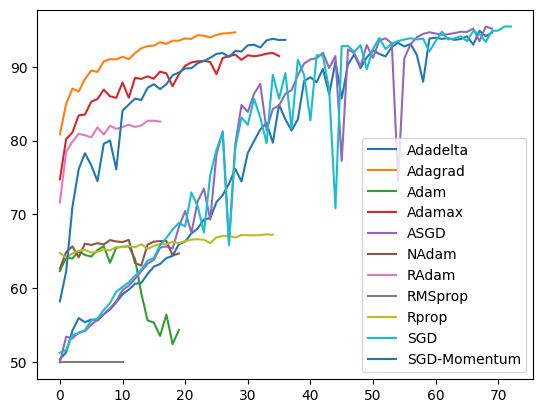

In [54]:
# Execute when there's csv
optim_accuracy_df = pd.read_csv('./model_histories/version_1/optim_accuracy_without_lrfinder.csv')
for col in optim_accuracy_df.columns:
    plt.plot(optim_accuracy_df[optim_accuracy_df[col].notna()][col], label = col)
plt.legend()
plt.show()

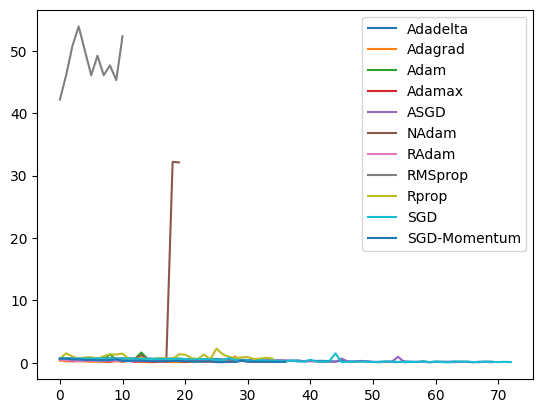

In [55]:
# Execute when there's csv
optim_loss_df = pd.read_csv('./model_histories/version_1/optim_loss_without_lrfinder.csv')
for col in optim_loss_df.columns:
    plt.plot(optim_loss_df[optim_loss_df[col].notna()][col], label = col)
plt.legend()
plt.show()

In [7]:
# Learning rate finder
input_dim = 1088
hidden_dim_0 = 1024
hidden_dim_1 = 512
hidden_dim_2 = 256
output_dim = 1
batch_size = 128

lr_finder_error = nn.BCELoss()
lr_finder_index = random.randint(0,len(csvs) - 1)
lr_finder_df = pd.read_csv("./lichess/data_1/" + csvs[lr_finder_index])
lr_finder_loader, _ = prepare_data(lr_finder_df, batch_size)

optimizer_dict = {
    "Adadelta": torch.optim.Adadelta,
    "Adagrad": torch.optim.Adagrad,
    "Adam": torch.optim.Adam,
    "Adamax": torch.optim.Adamax,
    "ASGD": torch.optim.ASGD,
    "NAdam": torch.optim.NAdam,
    "RAdam": torch.optim.RAdam,
    "RMSprop": torch.optim.RMSprop,
    "Rprop": torch.optim.Rprop,
    "SGD": torch.optim.SGD,
    "SGD-Momentum": torch.optim.SGD,
}
lr_results = {}
loss_results = {}
lr_find_range = (-6, 0)
init_lr = 1e-6

for algo_name, optimizer_class in optimizer_dict.items():
    print(algo_name.upper())
    model = ANNModel(input_dim, hidden_dim_0, hidden_dim_1, hidden_dim_2, output_dim)
    
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=init_lr, momentum=0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=init_lr)
        
    lr_list = []
    loss_list = []
    
    for lr in tqdm(torch.logspace(lr_find_range[0], lr_find_range[1], steps=100)):
        optimizer.param_groups[0]['lr'] = lr
        
        for _, (boards, labels) in enumerate(lr_finder_loader):
            train = Variable(boards.view(-1, input_dim))
            labels = Variable(labels.view(-1, 1))
            optimizer.zero_grad()
            outputs = model(train)
            loss = lr_finder_error(outputs, labels)
            loss.backward()
            optimizer.step()
            
        lr_list.append(lr)
        loss_list.append(loss.item())
        
    lr_results[algo_name] = lr_list
    loss_results[algo_name] = loss_list

ADADELTA


100%|█████████████████████████████████████████| 100/100 [39:03<00:00, 23.44s/it]


ADAGRAD


100%|█████████████████████████████████████████| 100/100 [39:57<00:00, 23.98s/it]


ADAM


100%|█████████████████████████████████████████| 100/100 [44:15<00:00, 26.56s/it]


ADAMAX


100%|█████████████████████████████████████████| 100/100 [49:26<00:00, 29.67s/it]


ASGD


  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/horatio/anaconda3/envs/seminar_chess/lib/python3.11/site-packages/torch/optim/asgd.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state["eta"] = torch.tensor(group["lr"])
100%|█████████████████████████████████████████| 100/100 [40:39<00:00, 24.39s/it]


NADAM


100%|█████████████████████████████████████████| 100/100 [49:15<00:00, 29.56s/it]


RADAM


100%|█████████████████████████████████████████| 100/100 [57:12<00:00, 34.32s/it]


RMSPROP


100%|█████████████████████████████████████████| 100/100 [27:04<00:00, 16.25s/it]


RPROP


100%|█████████████████████████████████████████| 100/100 [39:37<00:00, 23.77s/it]


SGD


100%|█████████████████████████████████████████| 100/100 [18:05<00:00, 10.85s/it]


SGD-MOMENTUM


100%|█████████████████████████████████████████| 100/100 [20:48<00:00, 12.49s/it]


In [8]:
max_len = max(len(lst) for lst in lr_results.values())
lr_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in lr_results.items()}
lr_df = pd.DataFrame(lr_filled_results)
lr_df.to_csv("./model_histories/version_1/learning_rate.csv", index = False)
lr_df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum
0,tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06),tensor(1.0000e-06)
1,tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06),tensor(1.1498e-06)
2,tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06),tensor(1.3219e-06)
3,tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06),tensor(1.5199e-06)
4,tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06),tensor(1.7475e-06)
...,...,...,...,...,...,...,...,...,...,...,...
95,tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722),tensor(0.5722)
96,tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579),tensor(0.6579)
97,tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565),tensor(0.7565)
98,tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697),tensor(0.8697)


In [9]:
max_len = max(len(lst) for lst in loss_results.values())
loss_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in loss_results.items()}
loss_df = pd.DataFrame(loss_filled_results)
loss_df.to_csv("./model_histories/version_1/loss.csv", index = False)
loss_df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum
0,0.691976,0.697142,0.692715,0.696015,0.692408,0.691877,0.692864,0.691204,0.690566,0.692092,0.694966
1,0.693429,0.693341,0.695150,0.688936,0.692290,0.686920,0.695710,0.693475,0.693913,0.692770,0.693545
2,0.692952,0.693565,0.693300,0.695755,0.692816,0.694610,0.688384,0.690705,0.686753,0.693359,0.693119
3,0.694464,0.694277,0.688448,0.690779,0.694464,0.688259,0.688119,0.696106,0.686646,0.693402,0.693127
4,0.691485,0.696991,0.687924,0.690581,0.696538,0.690530,0.689271,0.690263,0.680217,0.691813,0.692483
...,...,...,...,...,...,...,...,...,...,...,...
95,0.155996,0.195486,0.693026,0.683420,0.198620,0.698276,0.697721,0.745288,0.452824,0.260840,53.125000
96,0.148832,0.222410,0.701631,0.695289,0.191529,0.678129,0.692095,0.712041,0.551022,0.241047,54.687500
97,0.295603,0.127934,0.696277,0.718319,0.236151,0.693853,0.715583,0.699298,0.395263,0.207330,49.218750
98,0.181491,0.145402,0.707467,2.995724,0.265964,0.695368,0.709522,0.767137,0.484663,0.343217,44.531250


ValueError: x and y must have same first dimension, but have shapes (95,) and (39,)

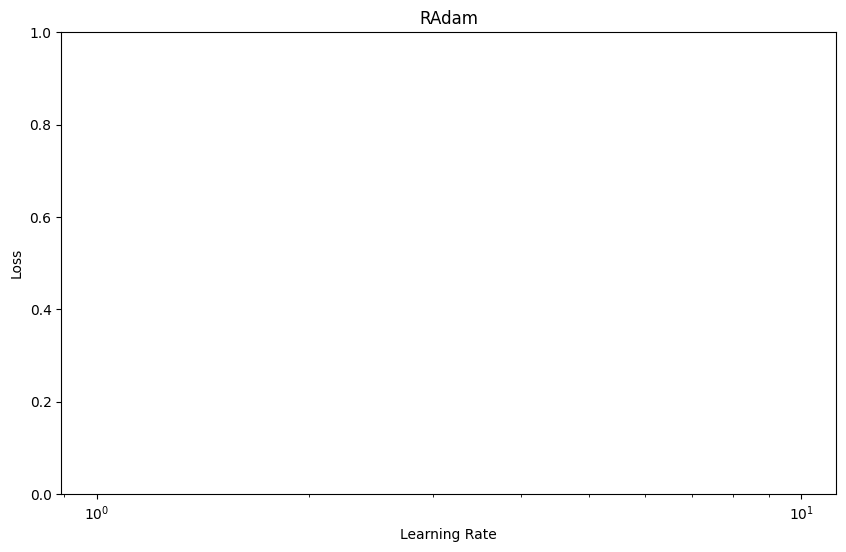

In [66]:
idx = 6
keys = list(lr_results.keys())
plt.figure(figsize=(10, 6))
plt.title(keys[idx])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.plot(lr_results[keys[idx]][:-5], loss_results[keys[idx]][:-5], marker='o')
plt.show()

In [57]:
# Code for testing the best algorithm for training
# Formatted by ChatGPT
error = nn.BCELoss()
val_error = nn.BCELoss()
# learning_rate = 0.001
input_dim = 1088
hidden_dim_0 = 1024
hidden_dim_1 = 512
hidden_dim_2 = 256
output_dim = 1
batch_size = 128

optimizer_dict = {
    "Adadelta": (torch.optim.Adadelta, 0.05),
    "Adagrad": (torch.optim.Adagrad, 1e-3),
    "Adam": (torch.optim.Adam, 1e-5),
    "Adamax": (torch.optim.Adamax, 5e-5),
    "ASGD": (torch.optim.ASGD, 0.05),
    "NAdam": (torch.optim.NAdam, 1e-5),
    "RAdam": (torch.optim.RAdam, 1e-5),
    "RMSprop": (torch.optim.RMSprop, 1e-5),
    "Rprop": (torch.optim.Rprop, 1e-5),
    "SGD": (torch.optim.SGD, 0.05),
    "SGD-Momentum": (torch.optim.SGD, 1e-3),
}

accuracy_results = {}
loss_results = {}
train_index = 42
while True:
    test_index = random.randint(0, len(csvs) - 1)
    if train_index != test_index:
        break
        
print(f"TRAIN_INDEX: {train_index}")
print(f"TEST_INDEX: {test_index}")

for algo_name, optimizer_tuple in optimizer_dict.items():
    model = ANNModel(input_dim, hidden_dim_0, hidden_dim_1, hidden_dim_2, output_dim)
    optimizer_class, learning_rate = optimizer_tuple
    
    if algo_name == "SGD-Momentum":
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    
    print(algo_name)
    
    accuracy_list = []
    loss_list = []
    train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
    test_df = pd.read_csv("./lichess/data_1/" + csvs[test_index])
    train_loader, test_loader = prepare_data(train_df, batch_size)
#     _, test_loader = prepare_data(test_df, batch_size)
    max_accuracy = 0
    min_loss = float('inf')
    epoch_count = 0

    while True:
        for _, (boards, labels) in enumerate(train_loader):
            train = Variable(boards.view(-1, input_dim))
            labels = Variable(labels.view(-1, 1))
            optimizer.zero_grad()
            outputs = model(train)
            loss = error(outputs, labels)
            loss.backward()
            optimizer.step()

        correct = 0
        total = 0

        for boards, labels in test_loader:
            test = Variable(boards.view(-1, input_dim))
            outputs = model(test)
            val_loss = val_error(outputs, labels.view(-1, 1)).detach().item()
            predicted = threshold_tensor(outputs)
            total += len(labels)
            correct += (predicted.flatten() == labels).sum()

        accuracy = 100 * correct / float(total)
        print(f"ACCURACY: {round(float(accuracy), 2)}%, LOSS: {round(float(val_loss), 4)}")
        
        if accuracy > max_accuracy:
            max_accuracy = accuracy

        if val_loss < min_loss:
            min_loss = val_loss
            epoch_count = 0
        else:
            epoch_count += 1

        accuracy_list.append(accuracy)
        loss_list.append(val_loss)

        if epoch_count >= 10:
            print(f"MAX_ACCURACY: {max_accuracy}")
            print(f"MIN_LOSS: {min_loss}")
            break
                
    accuracy_list_float = [float(tensor) for tensor in accuracy_list]
    loss_list_float = [float(tensor) for tensor in loss_list]
    accuracy_results[algo_name] = accuracy_list_float
    loss_results[algo_name] = loss_list_float

TRAIN_INDEX: 42
TEST_INDEX: 14
Adadelta
ACCURACY: 54.84%, LOSS: 0.6902
ACCURACY: 56.62%, LOSS: 0.6787
ACCURACY: 60.12%, LOSS: 0.6704
ACCURACY: 62.55%, LOSS: 0.6535
ACCURACY: 67.03%, LOSS: 0.6005
ACCURACY: 71.06%, LOSS: 0.5221
ACCURACY: 75.71%, LOSS: 0.4837
ACCURACY: 80.11%, LOSS: 0.3471
ACCURACY: 83.14%, LOSS: 0.2881
ACCURACY: 83.98%, LOSS: 0.3452
ACCURACY: 85.99%, LOSS: 0.3457
ACCURACY: 88.38%, LOSS: 0.2428
ACCURACY: 87.89%, LOSS: 0.2036
ACCURACY: 88.99%, LOSS: 0.2473
ACCURACY: 89.12%, LOSS: 0.2224
ACCURACY: 90.8%, LOSS: 0.1886
ACCURACY: 90.81%, LOSS: 0.2003
ACCURACY: 91.92%, LOSS: 0.1233
ACCURACY: 92.3%, LOSS: 0.1383
ACCURACY: 92.22%, LOSS: 0.1422
ACCURACY: 92.99%, LOSS: 0.1146
ACCURACY: 93.31%, LOSS: 0.1598
ACCURACY: 93.34%, LOSS: 0.1104
ACCURACY: 93.55%, LOSS: 0.1049
ACCURACY: 93.44%, LOSS: 0.1199
ACCURACY: 92.5%, LOSS: 0.2048
ACCURACY: 92.66%, LOSS: 0.1455
ACCURACY: 94.64%, LOSS: 0.1209
ACCURACY: 94.61%, LOSS: 0.1212
ACCURACY: 93.08%, LOSS: 0.1761
ACCURACY: 94.38%, LOSS: 0.103
ACC

ACCURACY: 91.97%, LOSS: 0.1928
ACCURACY: 92.03%, LOSS: 0.185
ACCURACY: 92.39%, LOSS: 0.1143
ACCURACY: 92.61%, LOSS: 0.2727
ACCURACY: 92.61%, LOSS: 0.1668
ACCURACY: 92.94%, LOSS: 0.1934
ACCURACY: 93.06%, LOSS: 0.1374
ACCURACY: 93.6%, LOSS: 0.1389
ACCURACY: 93.44%, LOSS: 0.1698
ACCURACY: 93.24%, LOSS: 0.1428
ACCURACY: 94.02%, LOSS: 0.1635
ACCURACY: 94.05%, LOSS: 0.108
ACCURACY: 92.83%, LOSS: 0.118
ACCURACY: 93.85%, LOSS: 0.1888
ACCURACY: 94.51%, LOSS: 0.1423
ACCURACY: 93.97%, LOSS: 0.1323
ACCURACY: 94.62%, LOSS: 0.1963
ACCURACY: 94.71%, LOSS: 0.0738
ACCURACY: 94.77%, LOSS: 0.1174
ACCURACY: 95.14%, LOSS: 0.1652
ACCURACY: 94.72%, LOSS: 0.0972
ACCURACY: 95.05%, LOSS: 0.0595
ACCURACY: 94.98%, LOSS: 0.1753
ACCURACY: 94.93%, LOSS: 0.1543
ACCURACY: 95.28%, LOSS: 0.1061
ACCURACY: 95.27%, LOSS: 0.2532
ACCURACY: 94.85%, LOSS: 0.1985
ACCURACY: 95.43%, LOSS: 0.0356
ACCURACY: 95.29%, LOSS: 0.1194
ACCURACY: 95.58%, LOSS: 0.1085
ACCURACY: 95.47%, LOSS: 0.2119
ACCURACY: 95.53%, LOSS: 0.1208
ACCURACY: 95

ACCURACY: 59.9%, LOSS: 0.6854
ACCURACY: 62.02%, LOSS: 0.6391
ACCURACY: 62.84%, LOSS: 0.7134
ACCURACY: 66.72%, LOSS: 0.5894
ACCURACY: 69.66%, LOSS: 0.5186
ACCURACY: 75.68%, LOSS: 0.4151
ACCURACY: 77.73%, LOSS: 0.4124
ACCURACY: 77.92%, LOSS: 0.4583
ACCURACY: 79.8%, LOSS: 0.3855
ACCURACY: 77.83%, LOSS: 0.3907
ACCURACY: 86.99%, LOSS: 0.2231
ACCURACY: 86.52%, LOSS: 0.1953
ACCURACY: 85.27%, LOSS: 0.2638
ACCURACY: 87.22%, LOSS: 0.2574
ACCURACY: 85.25%, LOSS: 0.2749
ACCURACY: 87.6%, LOSS: 0.1993
ACCURACY: 89.76%, LOSS: 0.1735
ACCURACY: 88.89%, LOSS: 0.3067
ACCURACY: 86.32%, LOSS: 0.2094
ACCURACY: 90.55%, LOSS: 0.1408
ACCURACY: 89.01%, LOSS: 0.2072
ACCURACY: 90.1%, LOSS: 0.2199
ACCURACY: 91.3%, LOSS: 0.2555
ACCURACY: 91.82%, LOSS: 0.1525
ACCURACY: 90.76%, LOSS: 0.1589
ACCURACY: 91.38%, LOSS: 0.1668
ACCURACY: 92.23%, LOSS: 0.1731
ACCURACY: 91.43%, LOSS: 0.1643
ACCURACY: 90.16%, LOSS: 0.1484
ACCURACY: 92.04%, LOSS: 0.15
MAX_ACCURACY: 92.234375
MIN_LOSS: 0.14083552360534668


In [58]:
accuracy_results_max = {}
for optim, scores in accuracy_results.items():
    max_score = np.mean(scores[-11:])
    accuracy_results_max[optim] = max_score
accuracy_results_max = dict(sorted(accuracy_results_max.items(), key=lambda item: item[1]))
accuracy_results_max

{'Rprop': 73.59588068181819,
 'SGD-Momentum': 90.98082386363636,
 'Adamax': 93.30397727272727,
 'SGD': 93.33416193181819,
 'ASGD': 93.73366477272727,
 'RMSprop': 94.49431818181819,
 'Adam': 94.6015625,
 'Adagrad': 95.27414772727273,
 'RAdam': 95.3995028409091,
 'NAdam': 95.56463068181819,
 'Adadelta': 95.77485795454545}

In [59]:
loss_results_max = {}
for optim, scores in loss_results.items():
    max_score = np.mean(scores[-11:])
    loss_results_max[optim] = max_score
loss_results_max = dict(sorted(loss_results_max.items(), key=lambda item: item[1]))
loss_results_max

{'Adadelta': 0.09730042212388733,
 'Adagrad': 0.10894817892800678,
 'NAdam': 0.11103130233558742,
 'Adam': 0.1280488446354866,
 'RAdam': 0.13118285956707867,
 'RMSprop': 0.1361372389576652,
 'SGD': 0.15713702616366473,
 'ASGD': 0.15934773873199115,
 'Adamax': 0.1705974652008577,
 'SGD-Momentum': 0.1761246215213429,
 'Rprop': 0.5986492173238234}

In [60]:
# Find the maximum length of lists in the dictionary
max_len = max(len(lst) for lst in accuracy_results.values())

# Fill shorter lists with None to make them equal in length
accuracy_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in accuracy_results.items()}

In [61]:
# Find the maximum length of lists in the dictionary
loss_max_len = max(len(lst) for lst in loss_results.values())

# Fill shorter lists with None to make them equal in length
loss_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in loss_results.items()}

In [62]:
optim_accuracy_df = pd.DataFrame(accuracy_filled_results)
optim_accuracy_df.to_csv("./model_histories/version_1/optim_accuracy_with_lrfinder.csv", index = False)
optim_accuracy_df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum
0,54.839844,70.886719,59.453125,61.257812,53.800781,59.453125,58.980469,59.023438,53.394531,52.984375,53.269531
1,56.625000,79.421875,63.441406,65.070312,58.070312,63.941406,65.636719,62.207031,55.761719,58.367188,55.125000
2,60.121094,84.195312,67.234375,68.085938,61.234375,67.101562,68.968750,65.187500,57.714844,61.730469,58.171875
3,62.546875,87.105469,68.480469,70.398438,62.101562,69.472656,71.640625,66.855469,59.507812,65.347656,59.898438
4,67.031250,88.691406,70.332031,73.363281,65.750000,71.425781,76.605469,67.664062,59.300781,65.425781,62.023438
...,...,...,...,...,...,...,...,...,...,...,...
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.847656,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.632812,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.027344,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.132812,NaN,NaN


In [63]:
optim_loss_df = pd.DataFrame(loss_filled_results)
optim_loss_df.to_csv("./model_histories/version_1/optim_loss_with_lrfinder.csv", index = False)
optim_loss_df

,Adadelta,Adagrad,Adam,Adamax,ASGD,NAdam,RAdam,RMSprop,Rprop,SGD,SGD-Momentum
0,0.690218,0.579089,0.679589,0.650782,0.689774,0.672283,0.687292,0.675243,0.691746,0.693347,0.690420
1,0.678733,0.497116,0.640616,0.684407,0.688947,0.628670,0.693517,0.635304,0.689687,0.674004,0.697437
2,0.670447,0.399191,0.645205,0.634290,0.655261,0.609653,0.623757,0.630775,0.683253,0.654602,0.687055
3,0.653478,0.277791,0.662100,0.567463,0.653807,0.613305,0.529072,0.612911,0.686485,0.578489,0.685359
4,0.600482,0.289787,0.640012,0.588641,0.601085,0.544969,0.447509,0.579077,0.686771,0.585550,0.639150
...,...,...,...,...,...,...,...,...,...,...,...
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531225,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.529769,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.482391,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.513610,NaN,NaN


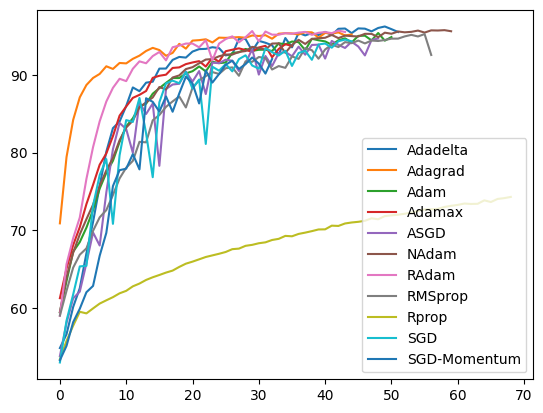

In [64]:
# Execute when there's csv
optim_accuracy_df = pd.read_csv('./model_histories/version_1/optim_accuracy_with_lrfinder.csv')
for col in optim_accuracy_df.columns:
    plt.plot(optim_accuracy_df[optim_accuracy_df[col].notna()][col], label = col)
plt.legend()
plt.show()

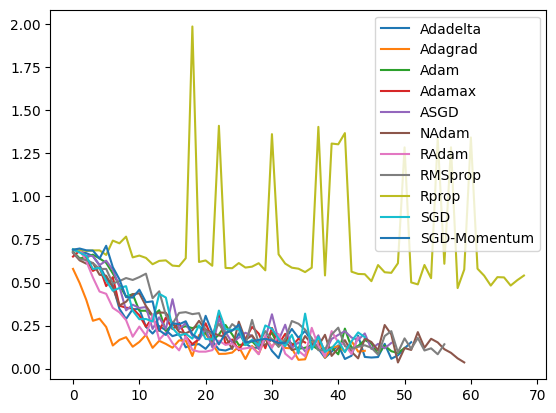

In [65]:
# Execute when there's csv
optim_loss_df = pd.read_csv('./model_histories/version_1/optim_loss_with_lrfinder.csv')
for col in optim_loss_df.columns:
    plt.plot(optim_loss_df[optim_loss_df[col].notna()][col], label = col)
plt.legend()
plt.show()

In [17]:
# Finding out the best structure for neural network
# Number of hidden layers = 3
n_neurons = [256, 512, 1024, 2048]
error = nn.BCELoss()
val_error = nn.BCELoss()
# learning_rate = 0.001
input_dim = 1088
output_dim = 1
batch_size = 128

accuracy_results = {}
loss_results = {}
train_index = random.randint(0,len(csvs) - 1)
train_df = pd.read_csv("./lichess/data_1/" + csvs[train_index])
train_loader, test_loader = prepare_data(train_df, batch_size)
        
print(f"TRAIN_INDEX: {train_index}")

for hidden_dim_0 in n_neurons:
    for hidden_dim_1 in n_neurons:
        for hidden_dim_2 in n_neurons:
            print(f'{hidden_dim_0}-{hidden_dim_1}-{hidden_dim_2}')

            model = ANNModel(input_dim, hidden_dim_0, hidden_dim_1, hidden_dim_2, output_dim)
            optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)
            accuracy_list = []
            loss_list = []
            max_accuracy = 0
            min_loss = float('inf')
            epoch_count = 0

            while True:
                for _, (boards, labels) in enumerate(train_loader):
                    train = Variable(boards.view(-1, input_dim))
                    labels = Variable(labels.view(-1, 1))
                    optimizer.zero_grad()
                    outputs = model(train)
                    loss = error(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                correct = 0
                total = 0

                for boards, labels in test_loader:
                    test = Variable(boards.view(-1, input_dim))
                    outputs = model(test)
                    val_loss = error(outputs, labels.view(-1, 1)).detach().item()
                    predicted = threshold_tensor(outputs)
                    total += len(labels)
                    correct += (predicted.flatten() == labels).sum()
                
                accuracy = 100 * correct / float(total)
                print(f"ACCURACY: {round(float(accuracy), 2)}%, LOSS: {round(float(val_loss), 4)}")

                if accuracy > max_accuracy:
                    max_accuracy = accuracy

                if val_loss < min_loss:
                    min_loss = val_loss
                    epoch_count = 0
                else:
                    epoch_count += 1         

                accuracy_list.append(accuracy)
                loss_list.append(val_loss)

                if epoch_count >= 10:
                    print(f"MAX_ACCURACY: {max_accuracy}")
                    print(f"MIN_LOSS: {min_loss}")
                    break
            
            accuracy_list_float = [float(tensor) for tensor in accuracy_list]
            loss_list_float = [float(tensor) for tensor in loss_list]
            accuracy_results[f'{hidden_dim_0}-{hidden_dim_1}-{hidden_dim_2}'] = accuracy_list_float
            loss_results[f'{hidden_dim_0}-{hidden_dim_1}-{hidden_dim_2}'] = loss_list_float

TRAIN_INDEX: 7
256-256-256
ACCURACY: 51.06%, LOSS: 0.6918
ACCURACY: 55.89%, LOSS: 0.6792
ACCURACY: 60.27%, LOSS: 0.6766
ACCURACY: 63.23%, LOSS: 0.5971
ACCURACY: 65.29%, LOSS: 0.6359
ACCURACY: 68.55%, LOSS: 0.5943
ACCURACY: 73.59%, LOSS: 0.5383
ACCURACY: 76.08%, LOSS: 0.5039
ACCURACY: 79.09%, LOSS: 0.412
ACCURACY: 83.22%, LOSS: 0.35
ACCURACY: 85.38%, LOSS: 0.3175
ACCURACY: 86.89%, LOSS: 0.2551
ACCURACY: 87.87%, LOSS: 0.3395
ACCURACY: 85.16%, LOSS: 0.3714
ACCURACY: 89.43%, LOSS: 0.2538
ACCURACY: 89.81%, LOSS: 0.2266
ACCURACY: 88.18%, LOSS: 0.156
ACCURACY: 89.7%, LOSS: 0.2441
ACCURACY: 91.28%, LOSS: 0.1178
ACCURACY: 89.31%, LOSS: 0.1809
ACCURACY: 91.54%, LOSS: 0.2209
ACCURACY: 90.58%, LOSS: 0.1411
ACCURACY: 92.12%, LOSS: 0.1548
ACCURACY: 92.3%, LOSS: 0.1271
ACCURACY: 92.82%, LOSS: 0.1646
ACCURACY: 92.32%, LOSS: 0.0985
ACCURACY: 89.02%, LOSS: 0.5036
ACCURACY: 92.55%, LOSS: 0.2782
ACCURACY: 93.0%, LOSS: 0.179
ACCURACY: 83.95%, LOSS: 0.3112
ACCURACY: 93.4%, LOSS: 0.1263
ACCURACY: 93.59%, LOS

: 

In [ ]:
accuracy_results_max = {}
for optim, scores in accuracy_results.items():
    max_score = np.mean(scores[-11:])
    accuracy_results_max[optim] = max_score
accuracy_results_max = dict(sorted(accuracy_results_max.items(), key=lambda item: item[1]))
accuracy_results_max

In [ ]:
loss_results_max = {}
for optim, scores in loss_results.items():
    max_score = np.mean(scores[-11:])
    loss_results_max[optim] = max_score
loss_results_max = dict(sorted(loss_results_max.items(), key=lambda item: item[1]))
loss_results_max

In [ ]:
# Find the maximum length of lists in the dictionary
max_len = max(len(lst) for lst in accuracy_results.values())

# Fill shorter lists with None to make them equal in length
accuracy_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in accuracy_results.items()}

In [ ]:
# Find the maximum length of lists in the dictionary
loss_max_len = max(len(lst) for lst in loss_results.values())

# Fill shorter lists with None to make them equal in length
loss_filled_results = {k: v + [None] * (max_len - len(v)) for k, v in loss_results.items()}

In [ ]:
optim_accuracy_df = pd.DataFrame(accuracy_filled_results)
optim_accuracy_df.to_csv("./model_histories/version_1/architecture_selector_accuracy.csv", index = False)
optim_accuracy_df

In [ ]:
optim_loss_df = pd.DataFrame(loss_filled_results)
optim_loss_df.to_csv("./model_histories/version_1/architecture_selector_loss.csv", index = False)
optim_loss_df